https://www.youtube.com/watch?v=AQNK-aLJ_8k

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from scipy.special import erfc, erfinv


def get_binary_price(Y0, sigma, T, l=0):
    """Forecast probability of winning on a binary bet.

    For SCFT chapter 12 election prediction

    SCFT Equation 12.2


    Parameters
    ----------
    Y0 : float
        Current level of the underlying (estimated).
        Between 0 and 1, representing 0 to 100% vote share.
    sigma : float
        Volatility of the shadow brownian motion process.
        Should be non-negative.
    T : float
        Time at maturity. Should be positive.
    l : float (default: 0)
        Success threshold for the X process. Between -inf and +inf.

    Returns
    -------
    price : float
        Binary forecast probability, which can be interpreted as a price.
    """

    # TOP
    top = l - erfinv(2 * Y0 - 1) * np.exp((sigma**2) * T)

    # BOTTOM
    bottom_exponent = 2 * (sigma**2) * T

    bottom = np.sqrt(np.exp(bottom_exponent) - 1)

    # Main Calculation
    price = 0.5 * erfc(top / bottom)

    return price


def get_sigma(Y0, s, T):
    """Calculate the volatility of the underlying brownian motion.

    Maps underlying volatility s to brownian motion volatility sigma.

    SCFT Equation 12.2

    Parameters
    ----------
    Y0 : float
        Current level of the underlying (estimated).
        Between 0 and 1, representing 0 to 100% vote share.
    s : float
        Volatility of the underlying Y process.
        Should be non-negative.
    T : float
        Time at maturity. Should be positive.

    Returns:
    sigma : float
        Volatility of the shadow brownian motion process.
    """

    top_exponent = 2 * erfinv((2 * Y0 - 1) ** 2)
    top_log_input = 2 * np.pi * (s**2) * np.exp(top_exponent) + 1
    top = np.sqrt(np.log(top_log_input))

    bottom = np.sqrt(2 * T)

    sigma = top / bottom

    return sigma


def plot_price_df(
    df, title="Price vs. Volatility.", ylabel="Binary Formula Price ($)", **kwargs
):
    """Plot Binary Prices against volatility.

    Parameters
    ----------
    df : pd.DataFrame
        * Rows are volatility values
        * Columns are vote share fractions
        * Values are the binary price

    Returns
    -------
    ax : matplotlib axis
        * df rows are the x-axis
        * df values are the y-axis
        * df columns are the different lines
    """

    # Plot
    ax = df.plot(title=title, ylabel=ylabel, ylim=[-0.1, 1.1], **kwargs)

    # Legend
    legend_labels = [f"{share*100:0.0f} %" for share in df.columns]  # Format as %
    legend_labels

    ax.legend(
        title="Initial Vote Share:",
        labels=legend_labels,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )

    return ax

In [3]:
# PARAMETERS

Y0 = 0.45  # Vote Share

T = 30 * 5  # Time to Maturity

sigma = 0.04  # Volatility magnitude

# Price with lots of time:
get_binary_price(Y0, sigma, T=30 * 5).round(2)

0.42

In [4]:
# Price near election:
get_binary_price(Y0, sigma, T=1).round(2)

0.01

In [5]:
# Row Values
s_values = np.arange(0, 0.04, step=0.001)
s_values = pd.Series(s_values, name="volatility")

# Column Values
Y0_values = [0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35]

# Time to Maturity
T = 30 * 5

# Make Columns
data = {}
for Y0_value in Y0_values:

    data[Y0_value] = s_values.apply(
        lambda s_value: get_binary_price(Y0_value, s_value, T)
    )

# Make DataFrame
df = pd.DataFrame(data)
df.columns.name = "vote_share"
df.index = s_values

display(df.tail().round(2))

vote_share,0.65,0.60,0.55,0.50,0.45,0.40,0.35
volatility,,,,,,,
0.035,0.76,0.68,0.59,0.5,0.41,0.32,0.24
0.036,0.75,0.67,0.59,0.5,0.41,0.33,0.25
0.037,0.75,0.67,0.59,0.5,0.41,0.33,0.25
0.038,0.74,0.67,0.58,0.5,0.42,0.33,0.26
0.039,0.74,0.66,0.58,0.5,0.42,0.34,0.26


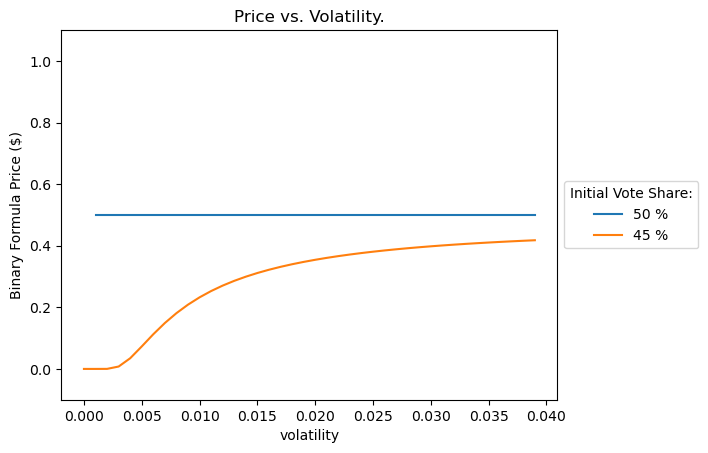

In [6]:
column_selection = [0.5, 0.45]

plot_price_df(df.loc[:, column_selection]);

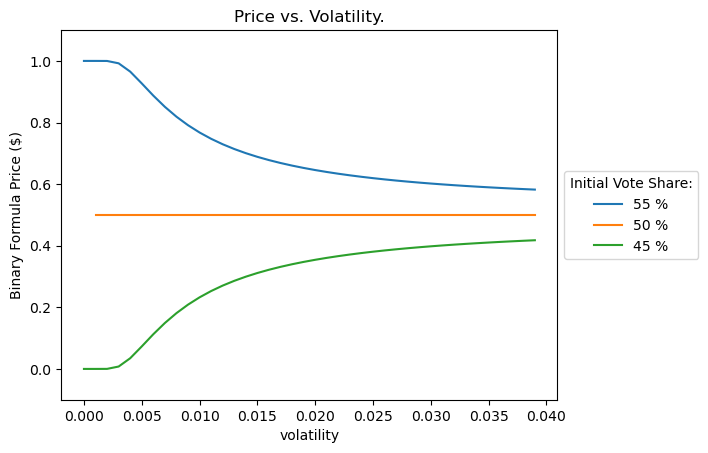

In [7]:
column_selection = [0.55, 0.5, 0.45]

plot_price_df(df.loc[:, column_selection]);

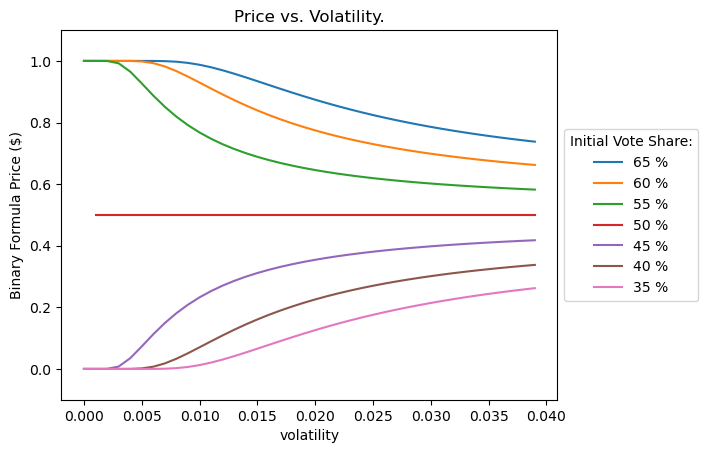

In [8]:
plot_price_df(df);

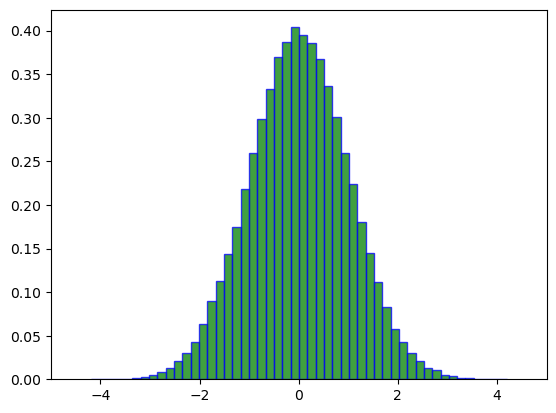

In [12]:
mu, sigma = 0, 1  # mean and standard deviation
s = np.random.normal(mu, sigma, 100000)

plt.hist(s, bins=50, density=True, color="g", alpha=0.75, edgecolor="b")
plt.xlim(-5, 5)
plt.show()

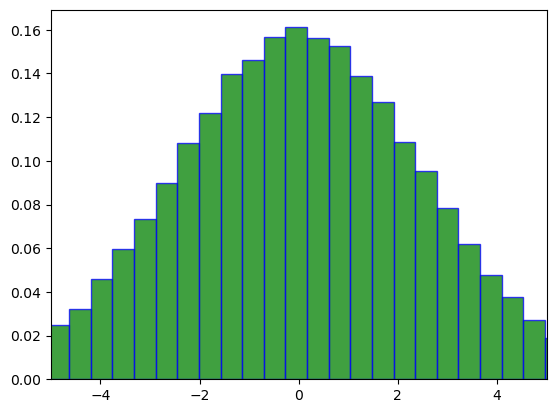

In [15]:
mu, sigma = 0, 2.5  # mean and standard deviation
s = np.random.normal(mu, sigma, 100000)

plt.hist(s, bins=50, density=True, color="g", alpha=0.75, edgecolor="b")
plt.xlim(-5, 5)
plt.show()

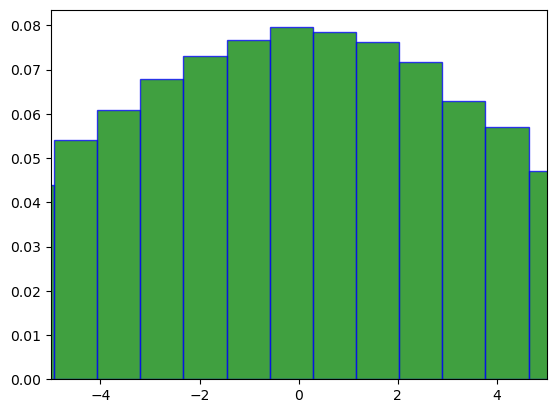

In [16]:
mu, sigma = 0, 5  # mean and standard deviation
s = np.random.normal(mu, sigma, 100000)

plt.hist(s, bins=50, density=True, color="g", alpha=0.75, edgecolor="b")
plt.xlim(-5, 5)
plt.show()

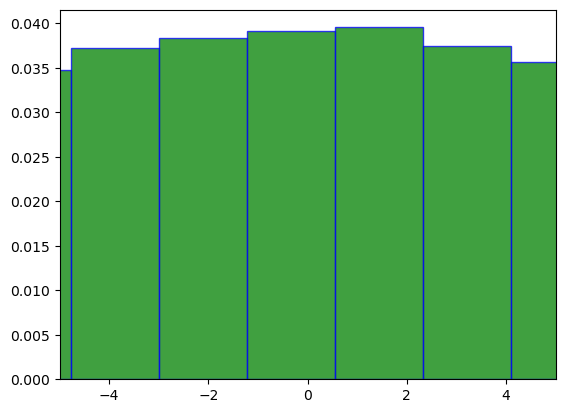

In [17]:
mu, sigma = 0, 10  # mean and standard deviation
s = np.random.normal(mu, sigma, 100000)

plt.hist(s, bins=50, density=True, color="g", alpha=0.75, edgecolor="b")
plt.xlim(-5, 5)
plt.show()

Distribution gets flater as volatility goes up. Hence the probabilities of winning election should be 50% each.

## Election Prediction

In [2]:
def calc_brier_score(arr, outturns):
    arr = np.array(arr)
    outturns = np.array(outturns)
    errors = arr - outturns
    return np.mean(errors**2)

In [19]:
naive_prediction = [0.5, 0.5, 0.5, 0.5]
informed_prediction = [1, 1, 1, 1]
outturns = [0, 0, 1, 1]  # actual outcomes

In [20]:
calc_brier_score(naive_prediction, outturns)

0.25

In [21]:
calc_brier_score(informed_prediction, outturns)

0.5

In [22]:
informed_prediction = [1, 0, 1, 1]
calc_brier_score(informed_prediction, outturns)

0.25

Conclusion: need to be right 75% of the time to get equivalent brier score to the naive predicitons